In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime

In [3]:
train_abbr=pd.read_csv("E:/Download/tianchi/happiness_train_abbr.csv",encoding='ISO-8859-1')
train=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
test_abbr=pd.read_csv("E:/Download/tianchi/happiness_test_abbr.csv",encoding='ISO-8859-1')
test=pd.read_csv("E:/Download/tianchi/happiness_test_complete.csv",encoding='ISO-8859-1')
test_sub=pd.read_csv("E:/Download/tianchi/happiness_submit.csv",encoding='ISO-8859-1')

In [4]:
test.shape

(2968, 139)

In [5]:
test_sub.shape

(2968, 2)

In [6]:
train.shape

(8000, 140)

In [7]:
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [8]:
train.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 140 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    8000 non-null   int64  
 1   happiness             8000 non-null   int64  
 2   survey_type           8000 non-null   int64  
 3   province              8000 non-null   int64  
 4   city                  8000 non-null   int64  
 5   county                8000 non-null   int64  
 6   survey_time           8000 non-null   object 
 7   gender                8000 non-null   int64  
 8   birth                 8000 non-null   int64  
 9   nationality           8000 non-null   int64  
 10  religion              8000 non-null   int64  
 11  religion_freq         8000 non-null   int64  
 12  edu                   8000 non-null   int64  
 13  edu_other             3 non-null      object 
 14  edu_status            6880 non-null   float64
 15  edu_yr              

In [9]:
y_train_=train["happiness"]

In [10]:
y_train_.value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [11]:
y_train_=y_train_.map(lambda x:3 if x==-8 else x)

In [12]:
data=pd.concat([train,test],axis=0,ignore_index=True)

In [13]:
data.shape

(10968, 140)

In [14]:
#处理时间特征
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y-%m-%d %H:%M:%S')
data["weekday"]=data["survey_time"].dt.weekday
data["year"]=data["survey_time"].dt.year
data["quarter"]=data["survey_time"].dt.quarter
data["hour"]=data["survey_time"].dt.hour
data["month"]=data["survey_time"].dt.month

In [15]:
def hour_cut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

    
data["hour_cut"]=data["hour"].map(hour_cut)

In [16]:
data["survey_age"]=data["year"]-data["birth"]

In [17]:
data["happiness"]=data["happiness"].map(lambda x:x-1)

In [18]:
data=data.drop(["edu_other"], axis=1)
data=data.drop(["happiness"], axis=1)
data=data.drop(["survey_time"], axis=1)

In [19]:
data["join_party"]=data["join_party"].map(lambda x:0 if pd.isnull(x)  else 1)

In [20]:
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    
data["birth_s"]=data["birth"].map(birth_split)
   

In [21]:
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5
 

    
data["income_cut"]=data["income"].map(income_cut)

In [22]:
data["edu_status"]=data["edu_status"].fillna(5)
data["edu_yr"]=data["edu_yr"].fillna(-2)
data["property_other"]=data["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["hukou_loc"]=data["hukou_loc"].fillna(1)
data["social_neighbor"]=data["social_neighbor"].fillna(8)
data["social_friend"]=data["social_friend"].fillna(8)
data["work_status"]=data["work_status"].fillna(0)
data["work_yr"]=data["work_yr"].fillna(0)
data["work_type"]=data["work_type"].fillna(0)
data["work_manage"]=data["work_manage"].fillna(0)
data["family_income"]=data["family_income"].fillna(-2)
data["invest_other"]=data["invest_other"].map(lambda x:0 if pd.isnull(x)  else 1)

In [23]:
#填充数据
data["minor_child"]=data["minor_child"].fillna(0)
data["marital_1st"]=data["marital_1st"].fillna(0)
data["s_birth"]=data["s_birth"].fillna(0)
data["marital_now"]=data["marital_now"].fillna(0)
data["s_edu"]=data["s_edu"].fillna(0)
data["s_political"]=data["s_political"].fillna(0)
data["s_hukou"]=data["s_hukou"].fillna(0)
data["s_income"]=data["s_income"].fillna(0)
data["s_work_exper"]=data["s_work_exper"].fillna(0)
data["s_work_status"]=data["s_work_status"].fillna(0)
data["s_work_type"]=data["s_work_type"].fillna(0)

In [24]:
data=data.drop(["id"], axis=1)

In [25]:
X_train_ = data[:train.shape[0]]
X_test_  = data[train.shape[0]:]

In [26]:
target_column = 'happiness'
feature_columns=list(X_test_.columns) 
feature_columns

['survey_type',
 'province',
 'city',
 'county',
 'gender',
 'birth',
 'nationality',
 'religion',
 'religion_freq',
 'edu',
 'edu_status',
 'edu_yr',
 'income',
 'political',
 'join_party',
 'floor_area',
 'property_0',
 'property_1',
 'property_2',
 'property_3',
 'property_4',
 'property_5',
 'property_6',
 'property_7',
 'property_8',
 'property_other',
 'height_cm',
 'weight_jin',
 'health',
 'health_problem',
 'depression',
 'hukou',
 'hukou_loc',
 'media_1',
 'media_2',
 'media_3',
 'media_4',
 'media_5',
 'media_6',
 'leisure_1',
 'leisure_2',
 'leisure_3',
 'leisure_4',
 'leisure_5',
 'leisure_6',
 'leisure_7',
 'leisure_8',
 'leisure_9',
 'leisure_10',
 'leisure_11',
 'leisure_12',
 'socialize',
 'relax',
 'learn',
 'social_neighbor',
 'social_friend',
 'socia_outing',
 'equity',
 'class',
 'class_10_before',
 'class_10_after',
 'class_14',
 'work_exper',
 'work_status',
 'work_yr',
 'work_type',
 'work_manage',
 'insur_1',
 'insur_2',
 'insur_3',
 'insur_4',
 'family_income'

In [27]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [28]:
X_train.shape

(8000, 145)

In [29]:
y_train.shape

(8000,)

In [30]:
X_test.shape

(2968, 145)

In [31]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [32]:
##### xgb

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[21:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:3.45054	train-myFeval:11.90626	valid_data-rmse:3.43893	valid_data-myFeval:11.82623
[100]	train-rmse:2.16703	train-myFeval:4.69601	valid_data-rmse:2.15725	valid_data-myFeval:4.65371
[200]	train-rmse:1.42042	train-myFeval:2.01760	valid_data-rmse:1.41700	valid_data-myFeval:2.00789
[300]	train-rmse:1.00611	train-myFeval:1.01225	valid_data-rmse:1.01465	valid_data-myFeval:1.02951
[400]	t

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:2.16848	train-myFeval:4.70231	valid_data-rmse:2.14897	valid_data-myFeval:4.61806
[200]	train-rmse:1.41984	train-myFeval:2.01595	valid_data-rmse:1.41577	valid_data-myFeval:2.00440
[300]	train-rmse:1.00380	train-myFeval:1.00761	valid_data-rmse:1.02010	valid_data-myFeval:1.04061
[400]	train-rmse:0.78839	train-myFeval:0.62155	valid_data-rmse:0.82746	valid_data-myFeval:0.68470
[500]	train-rmse:0.68360	train-myFeval:0.46730	valid_data-rmse:0.74297	valid_data-myFeval:0.55200
[600]	train-rmse:0.63275	train-myFeval:0.40037	valid_data-rmse:0.70846	valid_data-myFeval:0.50192
[700]	train-rmse:0.60520	train-myFeval:0.36627	valid_data-rmse:0.69434	valid_data-myFeval:0.48211
[800]	train-rmse:0.58800	train-myFeval:0.34575	valid_data-rmse:0.68850	valid_data-myFeval:0.47403
[900]	train-rmse:0.57542	train-myFeval:0.33111	valid_data-rmse:0.68524	valid_data-myFeval:0.46956
[1000]	train-rmse:0.56520	train-myFeval:0.31945	valid_data-rmse:0.68329	valid_data-myFeval:0.46689
[1100]	train-rmse:0

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°3
[21:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:3.44379	train-myFeval:11.85966	valid_data-rmse:3.46573	valid_data-myFeval:12.01126
[100]	train-rmse:2.16193	train-myFeval:4.67392	valid_data-rmse:2.18728	valid_data-myFeval:4.78420
[200]	train-rmse:1.41573	train-myFeval:2.00429	valid_data-rmse:1.45016	valid_data-myFeval:2.10297
[300]	train-rmse:1.00125	train-myFeval:1.00251	valid_data-rmse:1.04864	valid_data-myFeval:1.09965
[400]	t

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:2.16604	train-myFeval:4.69175	valid_data-rmse:2.17033	valid_data-myFeval:4.71035
[200]	train-rmse:1.41891	train-myFeval:2.01330	valid_data-rmse:1.43513	valid_data-myFeval:2.05959
[300]	train-rmse:1.00434	train-myFeval:1.00870	valid_data-rmse:1.03554	valid_data-myFeval:1.07234
[400]	train-rmse:0.78956	train-myFeval:0.62341	valid_data-rmse:0.83698	valid_data-myFeval:0.70053
[500]	train-rmse:0.68510	train-myFeval:0.46937	valid_data-rmse:0.74746	valid_data-myFeval:0.55869
[600]	train-rmse:0.63404	train-myFeval:0.40201	valid_data-rmse:0.70855	valid_data-myFeval:0.50204
[700]	train-rmse:0.60719	train-myFeval:0.36867	valid_data-rmse:0.69179	valid_data-myFeval:0.47857
[800]	train-rmse:0.59016	train-myFeval:0.34828	valid_data-rmse:0.68368	valid_data-myFeval:0.46742
[900]	train-rmse:0.57768	train-myFeval:0.33371	valid_data-rmse:0.67972	valid_data-myFeval:0.46202
[1000]	train-rmse:0.56720	train-myFeval:0.32171	valid_data-rmse:0.67733	valid_data-myFeval:0.45878
[1100]	train-rmse:0

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:2.16189	train-myFeval:4.67377	valid_data-rmse:2.19054	valid_data-myFeval:4.79844
[200]	train-rmse:1.41587	train-myFeval:2.00468	valid_data-rmse:1.45317	valid_data-myFeval:2.11171
[300]	train-rmse:1.00086	train-myFeval:1.00172	valid_data-rmse:1.05029	valid_data-myFeval:1.10311
[400]	train-rmse:0.78608	train-myFeval:0.61792	valid_data-rmse:0.85011	valid_data-myFeval:0.72269
[500]	train-rmse:0.68167	train-myFeval:0.46468	valid_data-rmse:0.75861	valid_data-myFeval:0.57549
[600]	train-rmse:0.63087	train-myFeval:0.39800	valid_data-rmse:0.71898	valid_data-myFeval:0.51693
[700]	train-rmse:0.60369	train-myFeval:0.36444	valid_data-rmse:0.70156	valid_data-myFeval:0.49218
[800]	train-rmse:0.58660	train-myFeval:0.34410	valid_data-rmse:0.69303	valid_data-myFeval:0.48029
[900]	train-rmse:0.57395	train-myFeval:0.32942	valid_data-rmse:0.68843	valid_data-myFeval:0.47393
[1000]	train-rmse:0.56357	train-myFeval:0.31761	valid_data-rmse:0.68586	valid_data-myFeval:0.47041
[1100]	train-rmse:0

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [33]:
##### lgb

param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
   # print(trn_idx)
   # print(".............x_train.........")
   # print(X_train[trn_idx])
  #  print(".............y_train.........")
  #  print(y_train[trn_idx])
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.43716	valid_1's l2: 0.469001
[400]	training's l2: 0.372054	valid_1's l2: 0.449059
[600]	training's l2: 0.331773	valid_1's l2: 0.443713
[800]	training's l2: 0.301111	valid_1's l2: 0.442274
[1000]	training's l2: 0.275824	valid_1's l2: 0.442014
Early stopping, best iteration is:
[914]	training's l2: 0.286025	valid_1's l2: 0.441698
fold n°2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.432323	valid_1's l2: 0.494649
[400]	training's l2: 0.367584	valid_1's l2: 0.469552
[600]	training's l2: 0.327795	valid_1's l2: 0.46228
[800]	training's l2: 0.2979	valid_1's l2: 0.459999
[1000]	training's l2: 0.272886	valid_1's l2: 0.45912

In [34]:
from catboost import Pool, CatBoostRegressor
# cat_features=[0,2,3,10,11,13,15,16,17,18,19]
from sklearn.model_selection import train_test_split


#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_, y_train_, test_size=0.3, random_state=2019)
# train_pool = Pool(X_train_s, y_train_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# val_pool = Pool(X_test_s, y_test_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# test_pool = Pool(X_test_ ,cat_features=[0,2,3,10,11,13,15,16,17,18,19]) 


kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits



print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))


fold n°0
0:	learn: 0.8175871	test: 0.7820939	best: 0.7820939 (0)	total: 155ms	remaining: 4h 19m 5s
100:	learn: 0.6711041	test: 0.6749289	best: 0.6749289 (100)	total: 733ms	remaining: 12m 4s
200:	learn: 0.6410910	test: 0.6688829	best: 0.6686703 (190)	total: 1.24s	remaining: 10m 15s
300:	learn: 0.6130819	test: 0.6669464	best: 0.6668201 (282)	total: 1.76s	remaining: 9m 44s
400:	learn: 0.5895197	test: 0.6666901	best: 0.6663658 (371)	total: 2.27s	remaining: 9m 24s
500:	learn: 0.5684832	test: 0.6657841	best: 0.6654600 (478)	total: 2.8s	remaining: 9m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6654599993
bestIteration = 478

Shrink model to first 479 iterations.
fold n°1
0:	learn: 0.8107754	test: 0.8172376	best: 0.8172376 (0)	total: 5.56ms	remaining: 9m 15s
100:	learn: 0.6715406	test: 0.6800052	best: 0.6800052 (100)	total: 570ms	remaining: 9m 23s
200:	learn: 0.6428284	test: 0.6699391	best: 0.6699391 (200)	total: 1s	remaining: 8m 16s
300:	learn: 0.6144500	test: 0.66

In [35]:
from sklearn import linear_model
# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train_)))


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.45363093


In [45]:
result=list(predictions)
result=list(map(lambda x: x + 1, result))
test_sub["happiness"]=result
test_sub.to_csv("submit_20220222.csv", index=False)

In [37]:
# !ls datalab/

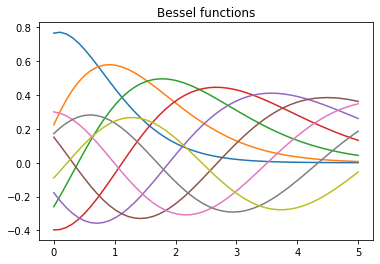

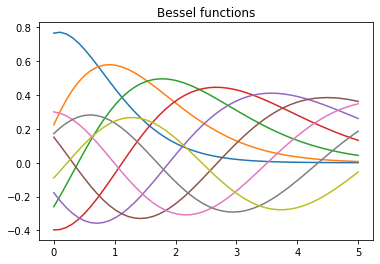

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from IPython.display import display, clear_output
import time
x = np.linspace(0,5)
f, ax = plt.subplots()
ax.set_title("Bessel functions")

for n in range(1,10):
    time.sleep(1)
    ax.plot(x, jn(x,n))
    clear_output(wait=True)
    display(f)

 
 